# Bias Reduction

Climate models can have biases relative to different verification products. Commonly, biases are reduced by post-processing model output before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [49]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

We start by loading in some sample sea surface temperature (SST) data from the [CESM Decadal Prediction Large Ensemble](https://journals.ametsoc.org/bams/article/99/9/1867/70398). The reconstruction is the forced ocean-sea ice (FOSI) simulation that initialized CESM-DPLE. We evalaute against this to evaluate potential predictability.

In [50]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST')  # CESM-DPLE hindcast ensemble output.
recon = climpred.tutorial.load_dataset('FOSI-SST')  # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v = 'SST'
alignment = 'same_verif'

The CESM-DPLE output is an anomaly forecast relative to 1964-2014. Thus, we remove the same time period from the verification data.

In [51]:
recon = recon - recon.sel(time=slice(1964, 2014)).mean('time')
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(recon, 'reconstruction')

/Users/rileybrady/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


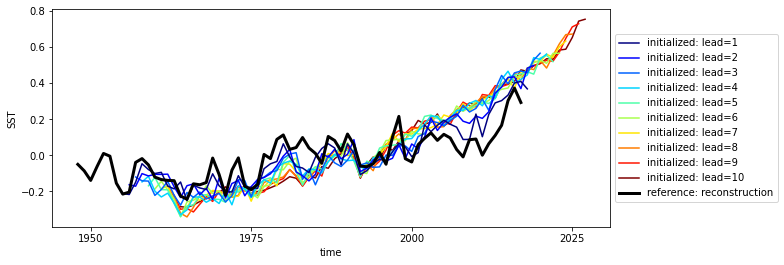

In [52]:
hindcast.plot()

## Mean bias reduction

Typically, bias is lead time dependent and thus should be removed as a function of lead time. We simply want to remove simple bias, so we will define a bias function to plug into `climpred`. See the [metrics](metrics.html#user-defined-metrics) page on how to plug in user-defined metrics.

In [53]:
from climpred.metrics import Metric
def bias_func(a, b, **kwargs):
    return a - b
bias_metric = Metric('bias',
                     bias_func,
                     positive=True,
                     probabilistic=False,
                     unit_power=1)

In [54]:
bias = hindcast.verify(metric=bias_metric,
                       comparison='e2o',
                       dim='init',
                       alignment=alignment).squeeze()

We now get a lead-dependent bias relative to the FOSI simulation. It is equivalent to the unconditional bias metric applied over the `member` dimension.

In [55]:
u_bias = hindcast.verify(metric='unconditional_bias', comparison='m2o',dim='member', alignment=alignment).squeeze()
xr.testing.assert_allclose(bias, u_bias)

We find a cold bias in the forecasts in early initializations and a warm bias in later initializations.

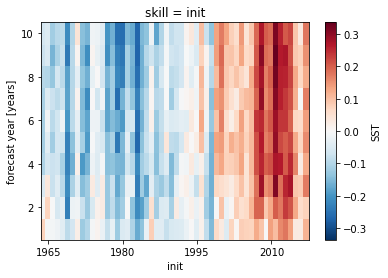

In [56]:
bias[v].plot()

### Cross Validation

`climpred` wraps these functions in `HindcastEnsemble.reduce_bias(how='mean', cross_validate={bool})`.

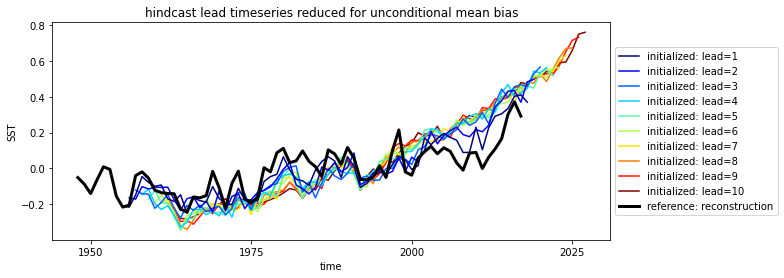

In [57]:
hindcast.reduce_bias(how='mean', cross_validate=True, alignment=alignment).plot()
plt.title('hindcast lead timeseries reduced for unconditional mean bias')
plt.show()

# Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias reduction. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

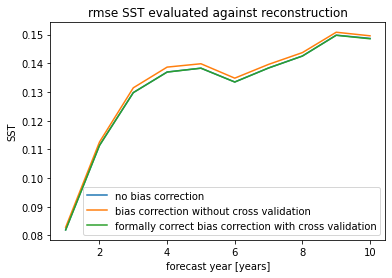

In [58]:
metric='rmse'
hindcast.verify(metric=metric, alignment=alignment)[v].plot(label='no bias correction')
hindcast.reduce_bias(cross_validate=False, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='bias correction without cross validation')
hindcast.reduce_bias(cross_validate=True, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"{metric} {v} evaluated against {list(hindcast._datasets['observations'].keys())[0]}")
plt.show()

## Aaron's Method

In [59]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST')  # CESM-DPLE hindcast ensemble output.
recon = climpred.tutorial.load_dataset('FOSI-SST')  # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v = 'SST'
alignment = 'same_verif'

In [60]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(recon, 'reconstruction')

/Users/rileybrady/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


Testing what happens when we do the climatology removal. I first remove the initialized climatology here, which is redundant (see below) and shouldn't be done.

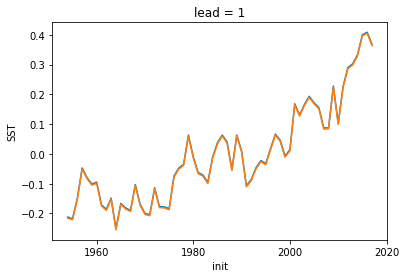

In [61]:
hindcast.get_initialized().mean('member').isel(lead=0).SST.plot()
(hindcast - hindcast.sel(init=slice('1964', '2014')).mean('init').sel(time=slice('1964', '2014')) \
     .mean('time')).get_initialized().mean('member').isel(lead=0).SST.plot()

Obviously this works...

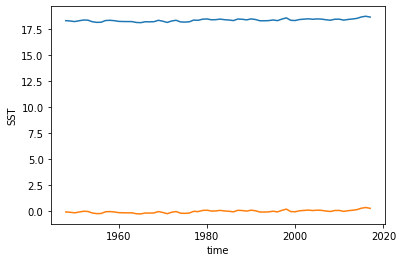

In [62]:
hindcast.get_observations().SST.plot()
(hindcast - hindcast.sel(init=slice('1964', '2014')).mean('init').sel(time=slice('1964', '2014')) \
     .mean('time')).get_observations().SST.plot()

Is it the same as removing it beforehand? Yes, it is. So what's happening here?

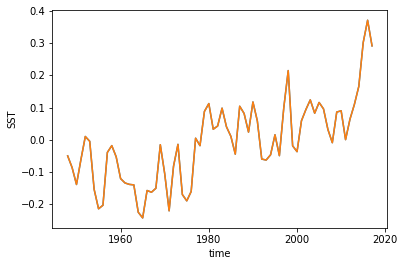

In [63]:
test = (hindcast - hindcast.sel(init=slice('1964', '2014')).mean('init').sel(time=slice('1964', '2014')) \
     .mean('time')).get_observations().SST
test.plot()
manual = recon - recon.sel(time=slice(1964, 2014)).mean('time')
manual['time'] = test['time']
manual.SST.plot()

**This isn't correct.** The initialized forecast (DPLE) is already bias-corrected over 1964-2014 so you're not supposed to remove that. You just need to remove the 1964-2014 climatology from the verification product to match up to the same initializations.

In [64]:
hindcast = hindcast - hindcast.sel(init=slice('1964', '2014')).mean('init').sel(time=slice('1964', '2014')).mean('time')

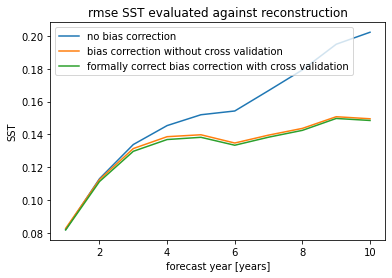

In [65]:
metric='rmse'
hindcast.verify(metric=metric, alignment=alignment)[v].plot(label='no bias correction')
hindcast.reduce_bias(cross_validate=False, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='bias correction without cross validation')
hindcast.reduce_bias(cross_validate=True, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"{metric} {v} evaluated against {list(hindcast._datasets['observations'].keys())[0]}")
plt.show()